In [25]:
# Celda 1 (actualizada)
from dotenv import load_dotenv
import os        # Importación agregada para acceder a las variables de entorno
import requests  # Importación agregada para realizar llamadas HTTP si se desea

load_dotenv()

True

In [26]:
# Nueva celda: Definición de la herramienta weatherbit_api
class WeatherbitAPI:
    def __init__(self):
        # Se obtiene la clave de la API desde el archivo .env
        self.api_key = os.getenv("WEATHERBIT_API_KEY")
    
    def invoke(self, args: dict) -> str:
        if not self.api_key:
            return "Error: Clave para Weatherbit no configurada"
        ciudad = args.get("ciudad", "")
        # Ejemplo de llamada real (descomentar para usarla realmente):
        # url = f"https://api.weatherbit.io/v2.0/current?city={ciudad}&key={self.api_key}&lang=es"
        # response = requests.get(url)
        # if response.status_code != 200:
        #     return "Servicio temporalmente no disponible"
        # data = response.json()
        # Aquí se procesarían los datos para retornar el resultado en español
        # Por simplicidad se retorna un resultado simulado:
        return "Soleado, 18°C"

# Instanciamos la herramienta para su registro
weatherbit_api = WeatherbitAPI()

### Nodes & Edges

In [27]:
from langchain_core.messages import HumanMessage
from langgraph.graph import END, MessageGraph
import time

def add_one(input: list[HumanMessage]):
    input[0].content = input[0].content + "a"
    time.sleep(1)
    return input

def add_z(input: list[HumanMessage]):
    input[0].content = input[0].content + "z"
    time.sleep(1)
    return input

def add_zero(input: list[HumanMessage]):
    input[0].content = input[0].content + "0"
    time.sleep(1)
    return input


graph = MessageGraph()

graph.add_node("branch_a", add_one)
graph.add_edge("branch_a", "branch_b")
graph.add_edge("branch_a", "branch_c")

graph.add_node("branch_b", add_one)
graph.add_node("branch_c", add_zero)

graph.add_edge("branch_b", "final_node")
graph.add_edge("branch_c", "final_node")

graph.add_node("final_node", add_z)
graph.add_edge("final_node", END)

graph.set_entry_point("branch_a")

runnable = graph.compile()

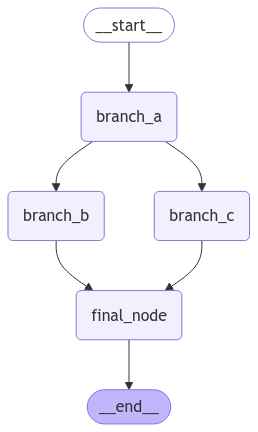

In [28]:
from IPython.display import Image, display

display(Image(runnable.get_graph().draw_mermaid_png()))

In [29]:
runnable.invoke("R")

[HumanMessage(content='Raa0z', additional_kwargs={}, response_metadata={}, id='e91f055f-320b-4f27-bbbe-573664e5b766')]

### Bordes Condicionales

In [30]:
from langchain_core.messages import HumanMessage
from langgraph.graph import END, MessageGraph


def entry(input: list[HumanMessage]):
    return input


def work_with_b(input: list[HumanMessage]):
    print("Usando rama B")
    return input


def work_with_c(input: list[HumanMessage]):
    print("Usando rama C")
    return input


def router(input: list[HumanMessage]):
    if "use_b" in input[0].content:
        return "branch_b"
    else:
        return "branch_c"


graph = MessageGraph()

graph.add_node("branch_a", entry)
graph.add_node("branch_b", work_with_b)
graph.add_node("branch_c", work_with_c)

# Agrega bordes condicionales al grafo:
# - El primer argumento "branch_a" es el nodo de origen
# - El segundo argumento "router" es la función que decide qué camino tomar
# - El tercer argumento es un diccionario que mapea los valores retornados por
#   el router a los nodos destino:
#   - Si router retorna "branch_b", el flujo va al nodo "branch_b"
#   - Si router retorna "branch_c", el flujo va al nodo "branch_c"
graph.add_conditional_edges(
    "branch_a", router, {"branch_b": "branch_b", "branch_c": "branch_c"}
)
graph.add_edge("branch_b", END)
graph.add_edge("branch_c", END)

graph.set_entry_point("branch_a")

runnable = graph.compile()

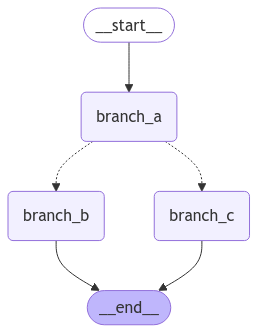

In [31]:
from IPython.display import Image, display

display(Image(runnable.get_graph().draw_mermaid_png()))

In [32]:
runnable.invoke("hello")

Usando rama C


[HumanMessage(content='hello', additional_kwargs={}, response_metadata={}, id='1451e1cb-84a8-4694-9560-a8e20cbc37da')]

In [33]:
runnable.invoke("No quiero usar use_b")

Usando rama B


[HumanMessage(content='No quiero usar use_b', additional_kwargs={}, response_metadata={}, id='80990ad2-ba86-40d1-8c65-c593d01f5254')]

In [34]:
runnable.invoke("Odio use_b")

Usando rama B


[HumanMessage(content='Odio use_b', additional_kwargs={}, response_metadata={}, id='cdc7c65e-8553-4d9f-8433-749cae88b30b')]

### Ciclos

In [35]:
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage
from langgraph.graph import END, MessageGraph

model = ChatOpenAI(temperature=0)


def entry(input: list[HumanMessage]):
    return input


def action(input: list[HumanMessage]):
    print("Acción tomada:", [msg.content for msg in input])
    if len(input) > 10:
        input.append(HumanMessage(content="end"))
    else:
        input.append(HumanMessage(content="continue"))
    return input


def should_continue(input: list):
    last_message = input[-1]
    if "end" in last_message.content:
        return "__end__"
    return "action"


graph = MessageGraph()

graph.add_node("agent", entry)
graph.add_node("action", action)

graph.add_conditional_edges(
    "agent", should_continue, {"action": "action", "__end__": END}
)
graph.add_edge("action", "agent")

graph.set_entry_point("agent")

runnable = graph.compile()

In [36]:
# Ejemplo de invocación para ciclos
from langchain_core.messages import HumanMessage

runnable.invoke(HumanMessage(content="hello"))

Acción tomada: ['hello']
Acción tomada: ['hello', 'continue']
Acción tomada: ['hello', 'continue', 'continue']
Acción tomada: ['hello', 'continue', 'continue', 'continue']
Acción tomada: ['hello', 'continue', 'continue', 'continue', 'continue']
Acción tomada: ['hello', 'continue', 'continue', 'continue', 'continue', 'continue']
Acción tomada: ['hello', 'continue', 'continue', 'continue', 'continue', 'continue', 'continue']
Acción tomada: ['hello', 'continue', 'continue', 'continue', 'continue', 'continue', 'continue', 'continue']
Acción tomada: ['hello', 'continue', 'continue', 'continue', 'continue', 'continue', 'continue', 'continue', 'continue']
Acción tomada: ['hello', 'continue', 'continue', 'continue', 'continue', 'continue', 'continue', 'continue', 'continue', 'continue']
Acción tomada: ['hello', 'continue', 'continue', 'continue', 'continue', 'continue', 'continue', 'continue', 'continue', 'continue', 'continue']


[HumanMessage(content='hello', additional_kwargs={}, response_metadata={}, id='77f6cb0b-8a9d-4ce1-8e88-c116c0c14802'),
 HumanMessage(content='continue', additional_kwargs={}, response_metadata={}, id='1bdb8c53-236b-4ccd-9dd6-7bac0b63f38d'),
 HumanMessage(content='continue', additional_kwargs={}, response_metadata={}, id='00235f35-25bd-4fdb-aa0f-7d94fab67721'),
 HumanMessage(content='continue', additional_kwargs={}, response_metadata={}, id='cc80b939-bfbd-4d2d-8a9e-d2d1e917578e'),
 HumanMessage(content='continue', additional_kwargs={}, response_metadata={}, id='2f7e11e5-362c-40fd-a226-6c6e39d36b8a'),
 HumanMessage(content='continue', additional_kwargs={}, response_metadata={}, id='de5c6c9f-c105-40dc-becb-cb9962eaf624'),
 HumanMessage(content='continue', additional_kwargs={}, response_metadata={}, id='fb118192-d17b-4ab0-a01c-e3caf5634ff9'),
 HumanMessage(content='continue', additional_kwargs={}, response_metadata={}, id='f61740c3-6f28-4826-9b98-3991f76df763'),
 HumanMessage(content='cont

### Agente Real - ahora creemos un agente que realmente haga algo

In [37]:
from langchain_openai import ChatOpenAI

model = ChatOpenAI(temperature=0)

In [38]:
from typing import TypedDict, Annotated, Sequence 
import operator
from langchain_core.messages import BaseMessage

class AgentState(TypedDict):
    # Esta clase define el estado del agente:
    # - messages: Una secuencia de mensajes que se pueden concatenar (usando operator.add)
    # - api_call_count: Un contador de llamadas a la API, inicializado en 0
    messages: Annotated[Sequence[BaseMessage], operator.add]
    api_call_count: int = 0

In [39]:
from langchain_core.tools import tool
import random

# Pendiente: Hacer que algunas veces la API de WeatherBit falle

@tool
def weatherbit_api(ciudad: str) -> str:
    """Consulta el clima actual usando la API de WeatherBit para una ciudad específica"""
    import requests
    import random
    
    # Simula una falla en el 60% de las llamadas
    if random.random() < 0.3:
        return "Servicio temporalmente no disponible"
    
    api_key = "e52b5895ccd743d0b5edaf98af5c7322"
    base_url = "https://api.weatherbit.io/v2.0/current"
    
    try:
        params = {
            "city": ciudad,
            "key": api_key,
            "lang": "es"
        }
        
        response = requests.get(base_url, params=params)
        response.raise_for_status()
        
        datos = response.json()
        
        if "data" in datos and len(datos["data"]) > 0:
            clima = datos["data"][0]
            temp = clima["temp"]
            descripcion = clima["weather"]["description"]
            return f"{descripcion}, {temp}°C"
        else:
            return "No se encontraron datos para esta ciudad"
            
    except Exception as e:
        return f"Error al consultar el servicio: {str(e)}"

# @tool
# def fake_weather_api(city: str) -> str:
#     """Consulta el clima en una ciudad especificada. La API está disponible aleatoriamente, aproximadamente cada tercera llamada."""

#     if random.randint(1, 3) == 1:  # Aproximadamente 1 de cada 3 llamadas
#         temp = random.randint(-5, 25)
#         weather = "Muy frío" if temp < 5 else "Nublado" if temp < 15 else "Soleado"
#         return f"{weather}, {temp}°C"
#     else:
#         return "Servicio temporalmente no disponible"

In [40]:
print(weatherbit_api.invoke({"ciudad": "Ciudad de México"}))
print(weatherbit_api.invoke({"ciudad": "Buenos Aires"}))
print(weatherbit_api.invoke({"ciudad": "Santiago"}))
print(weatherbit_api.invoke({"ciudad": "Lima"}))
print(weatherbit_api.invoke({"ciudad": "Bogotá"}))

Cielo despejado, 18.4°C
Cielo despejado, 30°C
Cielo despejado, 18.9°C
Servicio temporalmente no disponible
Cubierto, 13°C


In [41]:
llm_with_tools = model.bind_tools([weatherbit_api])

In [42]:
from langchain_core.messages import HumanMessage, ToolMessage

tool_mapping = {"weatherbit_api": weatherbit_api}

messages = [
    HumanMessage(
        "¿Cómo estará el clima en Ciudad de México hoy? Me gustaría comer al aire libre si es posible"
    )
]
llm_output = llm_with_tools.invoke(messages)
messages.append(llm_output)
print(messages)

[HumanMessage(content='¿Cómo estará el clima en Ciudad de México hoy? Me gustaría comer al aire libre si es posible', additional_kwargs={}, response_metadata={}), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_Ar7CqrNj5DJWebdPyoo98gSG', 'function': {'arguments': '{"ciudad":"Ciudad de México"}', 'name': 'weatherbit_api'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 80, 'total_tokens': 100, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-395f61f1-6987-407c-bf45-b167262d89c5-0', tool_calls=[{'name': 'weatherbit_api', 'args': {'ciudad': 'Ciudad de México'}, 'id': 'call_Ar7CqrNj5DJWebdPyoo98gSG', 'type': 'tool_call'}], usa

In [43]:
for tool_call in llm_output.tool_calls:
    tool = tool_mapping[tool_call["name"].lower()]
    tool_output = tool.invoke(tool_call["args"])
    messages.append(ToolMessage(content=tool_output, tool_call_id=tool_call["id"]))

llm_with_tools.invoke(messages)

AIMessage(content='Lo siento, parece que el servicio de clima no está disponible en este momento. ¿Hay algo más en lo que pueda ayudarte?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 31, 'prompt_tokens': 114, 'total_tokens': 145, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-6dd43504-3b63-4787-a5d3-b543b06cf9b4-0', usage_metadata={'input_tokens': 114, 'output_tokens': 31, 'total_tokens': 145, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [44]:
# Esta función determina si el agente debe continuar ejecutando acciones o terminar
# Recibe el estado actual del agente y analiza el último mensaje
# Si el último mensaje no tiene llamadas a herramientas, termina el flujo
# Si tiene llamadas pendientes, continúa la ejecución
def should_continue(state: AgentState):
    print("ESTADO:", state)
    messages = state["messages"]
    last_message = messages[-1]
    if not last_message.tool_calls:
        return "end"
    else:
        return "continue"


# Esta función se encarga de llamar al modelo de lenguaje con el estado actual
# Recibe el estado del agente que contiene los mensajes previos
# Invoca al modelo y retorna su respuesta junto con el contador de llamadas API
def call_model(state: AgentState):
    messages = state["messages"]
    response = llm_with_tools.invoke(messages)
    return {"messages": [response], "api_call_count": state["api_call_count"]}


# Esta función ejecuta las llamadas a las herramientas solicitadas por el modelo
# Obtiene la herramienta especificada del último mensaje y la invoca
# Incrementa el contador de llamadas API y registra la salida
# Retorna el mensaje de la herramienta y el contador actualizado
# Fragmento actualizado en la definición de call_tool (dentro de la celda que la contiene)
def call_tool(state: AgentState):
    messages = state["messages"]
    last_message = messages[-1]
    tool_call = last_message.tool_calls[0]
    # Si la llamada es para weatherbit_api y no está registrada aún, se registra
    if tool_call["name"].lower() == "weatherbit_api" and "weatherbit_api" not in tool_mapping:
        tool_mapping["weatherbit_api"] = weatherbit_api
    tool = tool_mapping[tool_call["name"].lower()]
    tool_output = tool.invoke(tool_call["args"])
    state["api_call_count"] += 1
    print("Salida de la herramienta:", tool_output)
    print("Cantidad de llamadas a la API después de esta herramienta:", state["api_call_count"])
    tool_message = ToolMessage(content=tool_output, tool_call_id=tool_call["id"])
    return {"messages": [tool_message], "api_call_count": state["api_call_count"]}

In [45]:
# Importamos las clases necesarias de langgraph
from langgraph.graph import StateGraph, END

# Creamos un nuevo grafo de estado que manejará el estado del agente
workflow = StateGraph(AgentState)

# Agregamos dos nodos al grafo:
# - "agent": ejecuta el modelo de lenguaje (call_model)
# - "action": ejecuta las herramientas (call_tool)
workflow.add_node("agent", call_model)
workflow.add_node("action", call_tool)

# Establecemos el punto de entrada del grafo en el nodo "agent"
workflow.set_entry_point("agent")

# Agregamos bordes condicionales desde el nodo "agent":
# - Si should_continue retorna "continue", va al nodo "action"
# - Si should_continue retorna "end", termina la ejecución
workflow.add_conditional_edges(
    "agent",
    should_continue,
    {
        "continue": "action",
        "end": END
    }
)

# Agregamos un borde desde "action" de vuelta a "agent"
# para crear el ciclo de ejecución
workflow.add_edge("action", "agent")

# Compilamos el grafo para crear la aplicación ejecutable
app = workflow.compile()

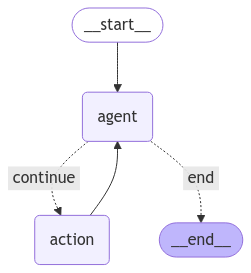

In [46]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except:
    pass

In [47]:
# Importamos la clase SystemMessage de langchain_core.messages
from langchain_core.messages import SystemMessage

# Creamos un mensaje del sistema que define el comportamiento del agente
# Este mensaje indica que el agente debe:
# - Responder preguntas de usuarios
# - Usar herramientas disponibles 
# - Ser resiliente ante fallos de las herramientas
system_message = SystemMessage(
    content="Eres responsable de responder las preguntas de los usuarios. Utilizas herramientas para ello; estas herramientas a veces fallan, pero eres muy resiliente y las intentas de nuevo"
)

# Creamos un mensaje del usuario con una pregunta sobre el clima
human_message = HumanMessage(content="¿Cómo está el clima en Ciudad de México hoy?")

# Combinamos ambos mensajes en una lista que será el historial de la conversación
messages = [system_message, human_message]

# Invocamos el grafo de ejecución (app) con:
# - El historial de mensajes
# - Un contador de llamadas a la API iniciado en 0
result = app.invoke({"messages": messages, "api_call_count": 0})

ESTADO: {'messages': [SystemMessage(content='Eres responsable de responder las preguntas de los usuarios. Utilizas herramientas para ello; estas herramientas a veces fallan, pero eres muy resiliente y las intentas de nuevo', additional_kwargs={}, response_metadata={}), HumanMessage(content='¿Cómo está el clima en Ciudad de México hoy?', additional_kwargs={}, response_metadata={}), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_vqV97ycCE5I3odeT8yVu2xgy', 'function': {'arguments': '{"ciudad":"Ciudad de México"}', 'name': 'weatherbit_api'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 110, 'total_tokens': 130, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'too

In [48]:
print(result["messages"][-1].content)
print(result["api_call_count"])

El clima en Ciudad de México hoy es de cielo despejado con una temperatura de 18.4°C. ¿Hay algo más en lo que pueda ayudarte?
1
